# Tutorial 06 - Alignment

## Dr. David C. Schedl

Note: this tutorial is geared towards students **experienced in programming** and aims to introduce you to **Computer Vision** techniques.


Useful links:
* OpenCV Tutorials: https://docs.opencv.org/master/d9/df8/tutorial_root.html
* Image Processing in Pyhton: https://github.com/xn2333/OpenCV/blob/master/Seminar_Image_Processing_in_Python.ipynb



# Table of Contents  

- Initialization
- SIFT 
- Least Squares Model
- Missmatches
- Warping
- Everything Combined


<a id="Initialization"></a>

# Initialization

As always let's import useful libraries, first. 
We will work with images today. So let's download some with `curl`.
Let's define utility functions to display images, in Jupyter Notebooks. OpenCV's `imshow` does not work and matplotlib's `imshow` needs special treatment due to color channel handling (RGB vs. BGR)

In [14]:
if 'google.colab' in str(get_ipython()):
  # install a newer opencv version on Colab. The default does not support SIFT!
  !pip install opencv-contrib-python==4.5.*

# import the libraries we use
import os
import cv2 # openCV
import numpy as np
import matplotlib.pyplot as plt



 
# loading images
!curl -o "campus.jpg" "https://www.fh-ooe.at/fileadmin/user_upload/hagenberg/fakultaet/aktuelles/bilder-videos/pics/fhooe-hagenberg-panorama-michael-fruehmann.jpg"
!curl -o "foto1A.jpg" "https://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg"
!curl -o "foto1B.jpg" "https://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg"

# utility function(s)
def imshow(image, *args, **kwargs):
    """A replacement for cv2.imshow() for use in Jupyter notebooks using matplotlib.

        Args:
          image : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. 
    """
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion  
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    # plt.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 24 2161k   24  531k    0     0  2888k      0 --:--:-- --:--:-- --:--:-- 2902k
100 2161k  100 2161k    0     0  8794k      0 --:--:-- --:--:-- --:--:-- 8822k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  9  161k    9 16384    0     0  15470      0  0:00:10  0:00:01  0:00:09 15485
100  161k  100  161k    0     0   109k      0  0:00:01  0:00:01 --:--:--  109k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:

# SIFT Descriptor and Feature Matching (from last Tutorial)

## Implementation of the Nearest Neighbor Distance Ratio Algorithm

This is the implementation of the previous tutorial.
Make sure that you have a recent OpenCV version installed. SIFT was patented and is only free since 2020.



In [15]:
def get_matched_points(kpsA, kpsB, featuresA, featuresB, matches):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
       
        return (ptsA, ptsB)
    else:
        return None

def get_nn_distance_ratio_matches(featuresA, featuresB, ratio=0.5):
    # Nearest Neigbhor Distance Ratio matching
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False) # init OpenCV's matcher

    rawMatches = bf.knnMatch(featuresB, featuresA, 2) # retrieves the two nearest neighbours
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)

    # sort based on the distance of the closest neighbour
    matches = sorted(matches, key = lambda x:x.distance)

    return matches


def do_sift_matching( imgA, imgB, ratio=0.5, show=True ):

    
    # convert to grayscale
    imgA_gray = cv2.cvtColor(imgA, cv2.COLOR_RGB2GRAY)
    imgB_gray = cv2.cvtColor(imgB, cv2.COLOR_RGB2GRAY)

    # init sift descriptor
    sift = cv2.SIFT_create()
   
    # get keypoints and descriptors
    (kpsA, featuresA) = sift.detectAndCompute(imgA_gray, None)
    (kpsB, featuresB) = sift.detectAndCompute(imgB_gray, None) # compute features for second image

    # do nn matching
    matches = get_nn_distance_ratio_matches(featuresA, featuresB, ratio)

    (ptsA, ptsB) = get_matched_points(kpsB, kpsA, featuresB, featuresA, matches[:])

    if show:
        # optionally, display (some) matches
        img_matches = cv2.drawMatches(imgB_gray,kpsB,imgA_gray,kpsA,matches[:1000:10],
                                None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the images better
        imshow(img_matches)
        plt.show()

    return ptsA, ptsB, matches


    

## Prepare the 'Campus' images

Create two images by extracting overlapping subregions from a large image. 
These can be stitched by finding correspondences.

The ground truth translation is [449, -41].

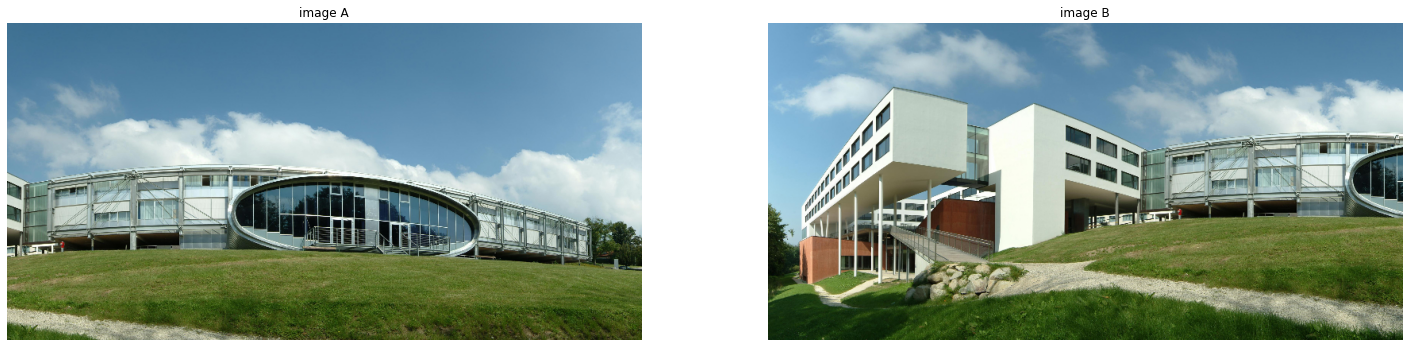

In [16]:
# read images and transform them to grayscale
# Make sure that the train image is the image that will be transformed

huge_img = cv2.imread("campus.jpg")

# create image A and B by extracting overlapping subregions from a large image
img = cv2.resize( huge_img, tuple((np.asarray(huge_img.shape[:2])/4).astype(np.int32))[::-1] )
imgA = img[:400,    -801:-1,:]
imgB = img[-401:-1, :800,   :]

# display
plt.figure(figsize=(25,10)) # this command makes the figure larger so we see the images better
plt.subplot(121), imshow(imgA, cmap="gray"), plt.title('image A')
plt.subplot(122), imshow(imgB, cmap="gray"), plt.title('image B')
plt.show()

## Feature Matching on the 'Campus' images

Let's do feature matching on the 'Campus' images with a nearest-neighbor distance ratio of `.5`.



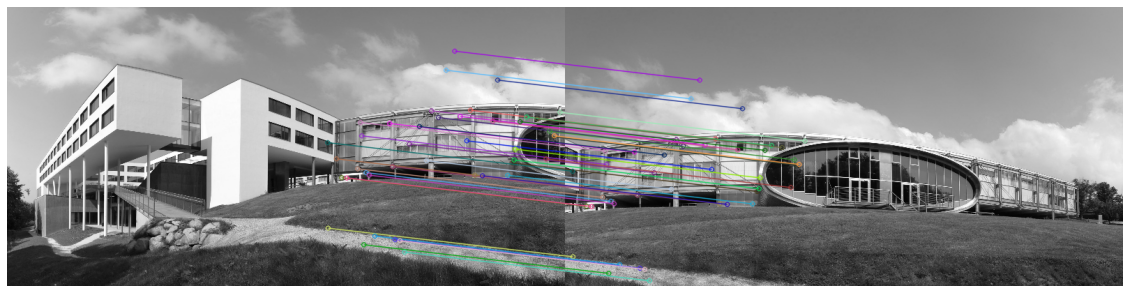

In [17]:
(ptsA, ptsB, matches) = do_sift_matching( imgA, imgB, ratio=0.5 )

**Geometric interpretation**: Let's look at the offsets (Δx and Δy) of matched features.

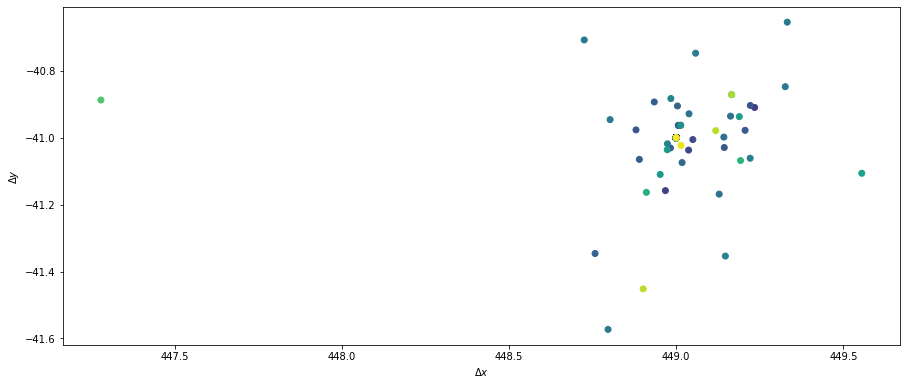

In [18]:
# plot the Δx and Δy of matched points
diff = ptsA - ptsB # compute offsets between matched points
simDistance = np.float32([m.distance for m in matches])

# display
fig = plt.figure(figsize=(15,10)) # this command makes the figure larger so we see the images better
ax = fig.add_subplot(111)
plt.scatter(diff[:,0],diff[:,1],c=simDistance,cmap='viridis')
#plt.xlim((0,500)), plt.ylim((-100,0))

ax.set_aspect('equal', adjustable='box'), plt.xlabel('$\Delta x$'), plt.ylabel('$\Delta y$')
plt.show()

**Another Geometric interpretation**: Let's look at the mappings from $x$ to $x'$ for each axis (horizontal and vertical) seperately.

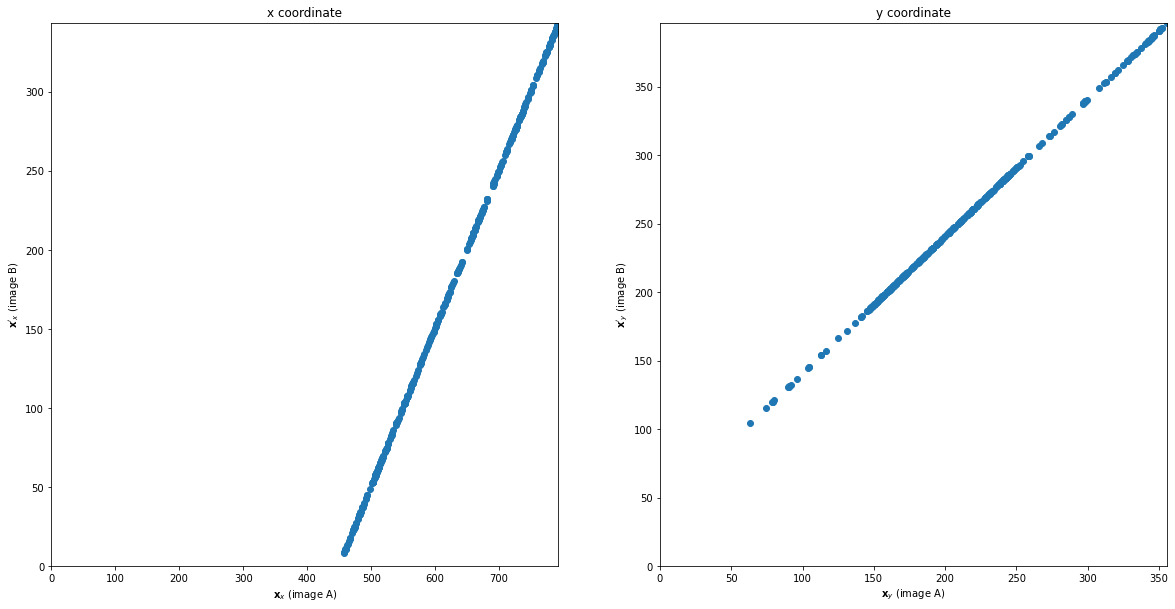

In [19]:

# display
fig = plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the images better
plt.subplot(121), plt.scatter(ptsA[:,0], ptsB[:,0]), plt.title( 'x coordinate' )
plt.xlabel('${\\bf x}_x$ (image A)'), plt.ylabel("${\\bf x'}_x$ (image B)")
plt.xlim((0,np.max((ptsA[:,0])))), plt.ylim((0,np.max((ptsB[:,0]))))
plt.subplot(122), plt.scatter(ptsA[:,1], ptsB[:,1]), plt.title( 'y coordinate' )
plt.xlabel('${\\bf x}_y$ (image A)'), plt.ylabel("${\\bf x'}_y$ (image B)")
plt.xlim((0,np.max((ptsA[:,1])))), plt.ylim((0,np.max((ptsB[:,1]))))


plt.show()

# Least Squares Model

Let's use a least-squares solver to find the parameters $t$ by minimizing the sum of squared residuals.
The model is $x' = x - t$.

Remember the ground truth translation ($t$) is [449, -41].

[449.00148132 -41.00114309]


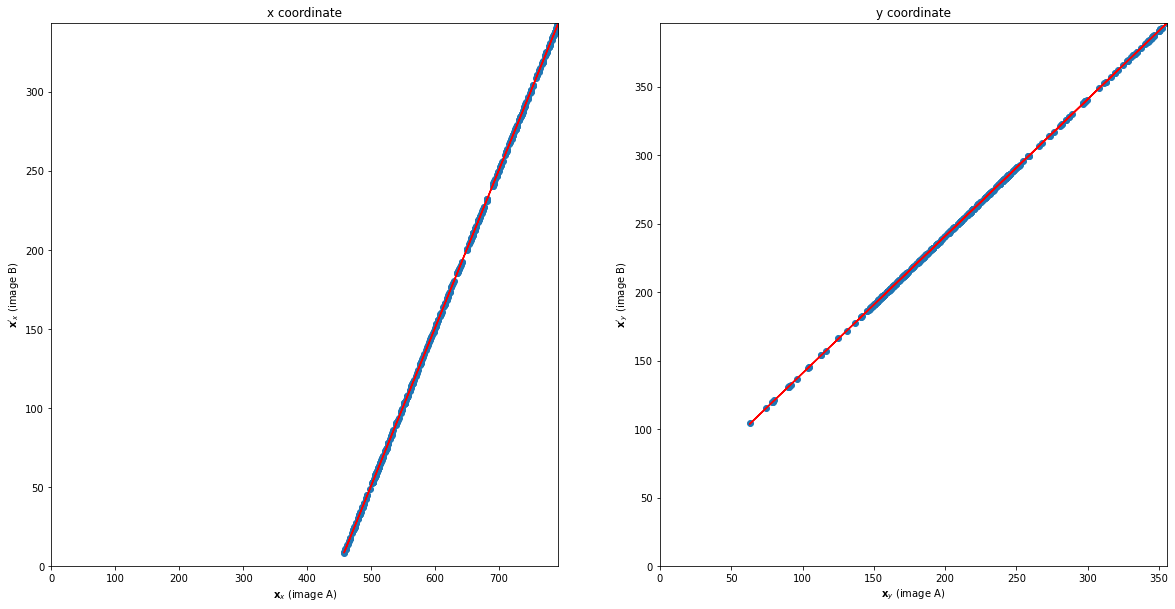

In [20]:
from scipy.optimize import least_squares

# define the translational model
def transl_model(t):
    residual = ptsA - (ptsB + t)
    return np.linalg.norm( residual, axis=1 )


t0 = np.array([0, 0]) # initial guess
res = least_squares(transl_model, t0) # solve with least squares solver
print(res.x)

# compute the x' for plotting
modelB = ptsA - res.x

# display
fig = plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the images better
plt.subplot(121), plt.scatter(ptsA[:,0], ptsB[:,0]), plt.title( 'x coordinate' )
plt.plot(ptsA[:,0], modelB[:,0], color='red')
plt.xlabel('${\\bf x}_x$ (image A)'), plt.ylabel("${\\bf x'}_x$ (image B)")
plt.xlim((0,np.max((ptsA[:,0])))), plt.ylim((0,np.max((ptsB[:,0]))))
plt.subplot(122), plt.scatter(ptsA[:,1], ptsB[:,1]), plt.title( 'y coordinate' )
plt.plot(ptsA[:,1], modelB[:,1], color='red')
plt.xlabel('${\\bf x}_y$ (image A)'), plt.ylabel("${\\bf x'}_y$ (image B)")
plt.xlim((0,np.max((ptsA[:,1])))), plt.ylim((0,np.max((ptsB[:,1]))))
plt.show()

The estimated parameters are very close to the ground truth. 
Remember the ground truth translation ($t$) is [449, -41].

# Missmatches



## Erroneous Feature Matching on the 'Campus' images

Sometimes missmatches are introduced by feature matching.
Let's simulate this with a nearest-neighbor distance ratio of `.95`.

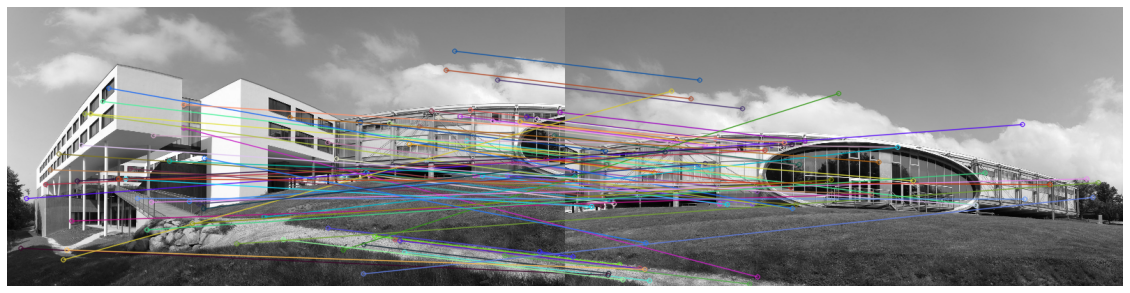

In [21]:
(ptsA, ptsB, matches) = do_sift_matching( imgA, imgB, ratio=0.95 )

## Least Squares

Outliers are a huge problem for LS!


[186.49025265 -25.35848531]


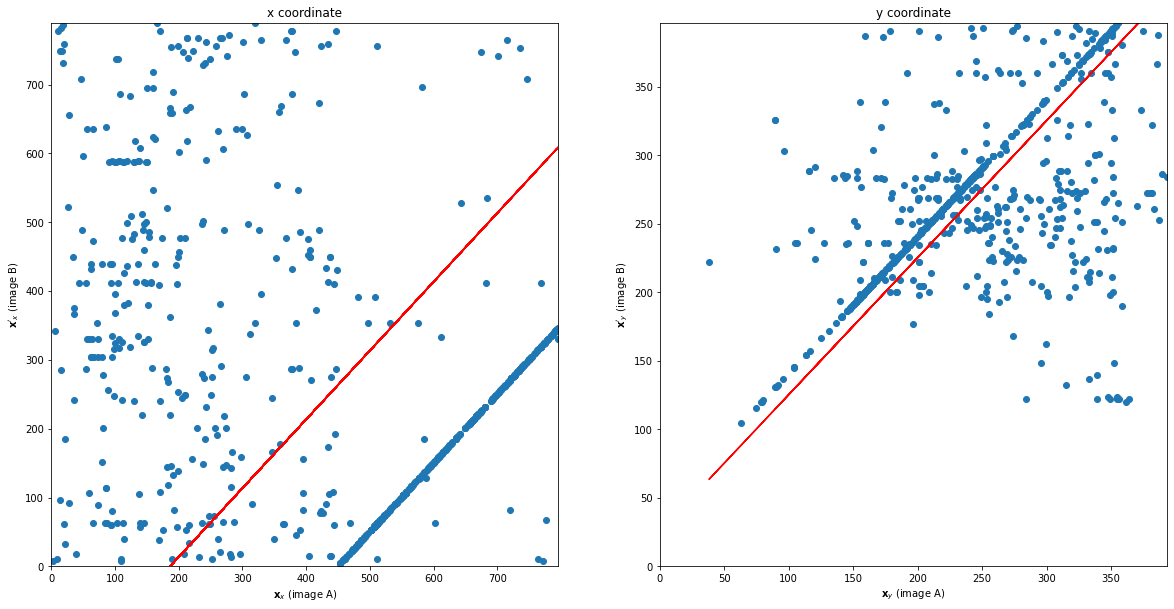

In [22]:
from scipy.optimize import least_squares

# define the translational model
def transl_model(t):
    residual = ptsA - (ptsB + t)
    return np.linalg.norm( residual, axis=1 )


t0 = np.array([0, 0]) # initial guess
res = least_squares(transl_model, t0)
print(res.x)

# compute the x' for plotting
modelB = ptsA - res.x

# display
fig = plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the images better
plt.subplot(121), plt.scatter(ptsA[:,0], ptsB[:,0]), plt.title( 'x coordinate' )
plt.plot(ptsA[:,0], modelB[:,0], color='red')
plt.xlabel('${\\bf x}_x$ (image A)'), plt.ylabel("${\\bf x'}_x$ (image B)")
plt.xlim((0,np.max((ptsA[:,0])))), plt.ylim((0,np.max((ptsB[:,0]))))
plt.subplot(122), plt.scatter(ptsA[:,1], ptsB[:,1]), plt.title( 'y coordinate' )
plt.plot(ptsA[:,1], modelB[:,1], color='red')
plt.xlabel('${\\bf x}_y$ (image A)'), plt.ylabel("${\\bf x'}_y$ (image B)")
plt.xlim((0,np.max((ptsA[:,1])))), plt.ylim((0,np.max((ptsB[:,1]))))
plt.show()

Again the ground truth translation ($t$) is [449, -41], but the least-squares solution is pretty off this time. 

## RANSAC (RANdom SAmple Consensus)

RANSAC on the other hand, can deal with outliers.

[448.99097791 -41.01486965]


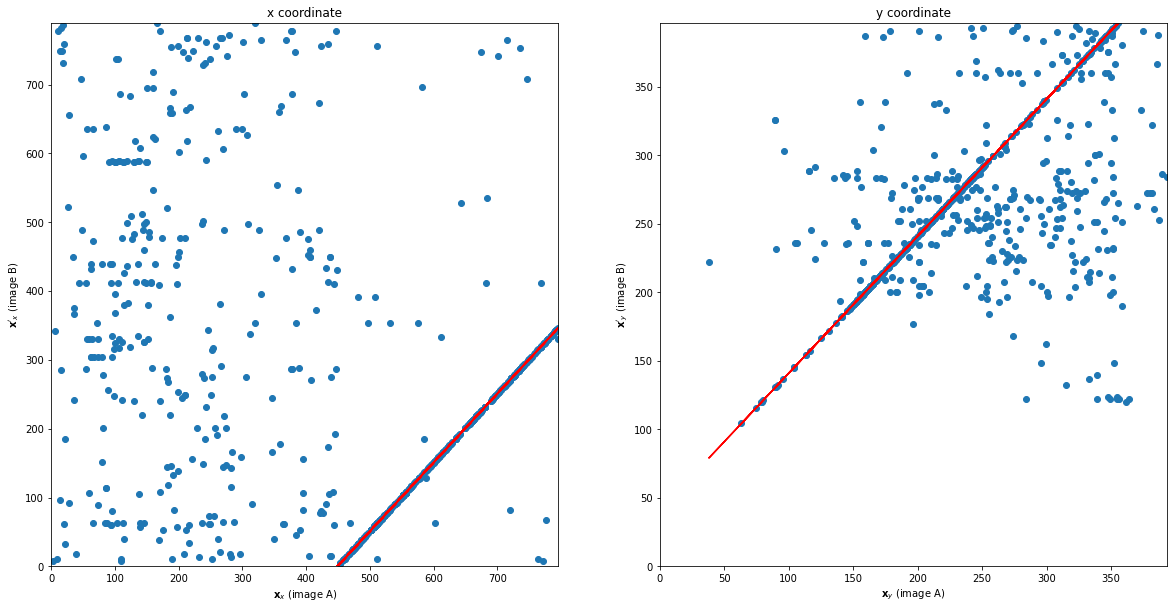

In [23]:
# estimate using RANSAC
(H, status) = cv2.estimateAffine2D(ptsB, ptsA, cv2.RANSAC)
print(H[:,2]) # translation

modelB = ptsA - H[:,2]

# display
fig = plt.figure(figsize=(20,10)) # this command makes the figure larger so we see the images better
plt.subplot(121), plt.scatter(ptsA[:,0], ptsB[:,0]), plt.title( 'x coordinate' )
plt.plot(ptsA[:,0], modelB[:,0], color='red')
plt.xlabel('${\\bf x}_x$ (image A)'), plt.ylabel("${\\bf x'}_x$ (image B)")
plt.xlim((0,np.max((ptsA[:,0])))), plt.ylim((0,np.max((ptsB[:,0]))))
plt.subplot(122), plt.scatter(ptsA[:,1], ptsB[:,1]), plt.title( 'y coordinate' )
plt.plot(ptsA[:,1], modelB[:,1], color='red')
plt.xlabel('${\\bf x}_y$ (image A)'), plt.ylabel("${\\bf x'}_y$ (image B)")
plt.xlim((0,np.max((ptsA[:,1])))), plt.ylim((0,np.max((ptsB[:,1]))))
plt.show()



# Warping

## Translational Model

Let's merge the two images by translating/warping one image (image A). 
So we assume that a point $\bf x$ in one image corresponds to $\bf x' = \bf x + \bf t$ in the second image, where $\bf t=[449,-41]$ is the translation.

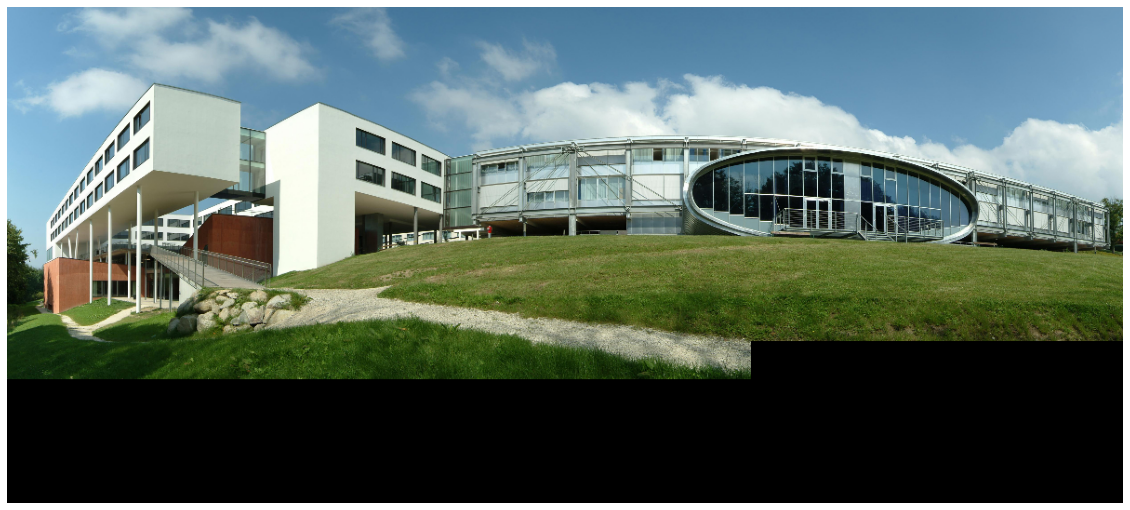

In [24]:
# the translation as matrix
H = np.float32([
	[1, 0, 449],
	[0, 1, -41]
])

# make sure the new image is large enough
width  = imgA.shape[1] + int(imgB.shape[1]/2)
height = imgA.shape[0] + int(imgB.shape[0]/3)

# warp image A to image B
result = cv2.warpAffine(imgA, H, (width, height))
result[0:imgB.shape[0], 0:imgB.shape[1]] = imgB # copy image B on top of warped image A

plt.figure(figsize=(20,10))
imshow(result)
plt.show()

## ⌨️ Try it yourself: Implement your own transformation

Play around with the transformation matrix and design your own warped image.

Challenge: 
 - Rotate the image by 90°.
 - Flip the image horizontally.
 - Can you combine multiple transformations? How? Does the order matter?


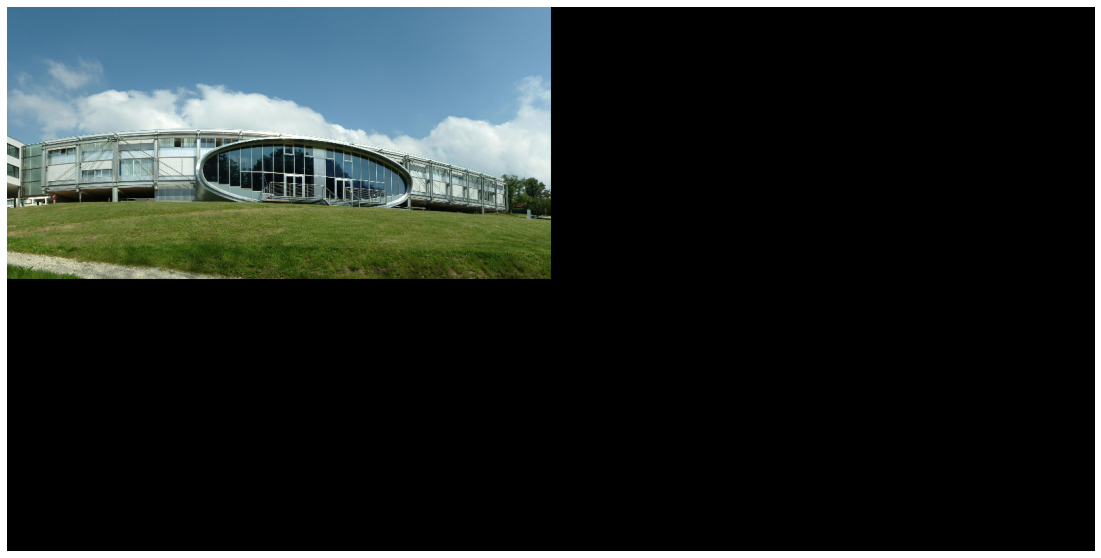

In [25]:
# the transformation matrices:

## ToDo: change matrix
H = np.float32([
	[1, 0, 0],
	[0, 1, 0]
])

# make sure the new image is large enough
width  = imgA.shape[1]*2
height = imgA.shape[0]*2

# warp image A to image B
warped = cv2.warpAffine(imgA, H, (width, height))

plt.figure(figsize=(20,10))
imshow(warped)
plt.show()

# Everything (in one line): OpenCV's Image Stitcher 

We could have avoided computing features, matching them, estimating translation and warping by simply using OpenCV's image stitcher. It does something similar like what we did and furthermore smoothly blends images. But where is the fun in that? 😃

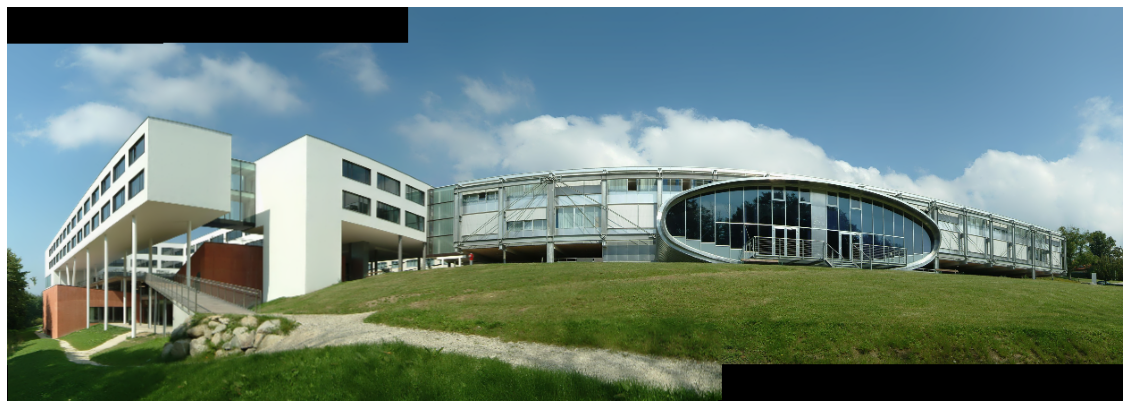

In [26]:
# initialize OpenCV's image stitcher object and then perform the image
# stitching
images = [imgA, imgB]
stitcher = cv2.Stitcher_create( mode=1 ) # mode=0 is panorama and assumes spherical stitichg, mode=1 is scan
(status, stitched) = stitcher.stitch(images)

if status==0: # stitching worked!
  plt.figure(figsize=(20,10))
  imshow(stitched)